read about perlin noise for initial landscape
https://en.wikipedia.org/wiki/Perlin_noise

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML


plt.rcParams["animation.html"] = "jshtml"

In [45]:
tmap = np.zeros((10, 10))
tmap[5, 5] = 10

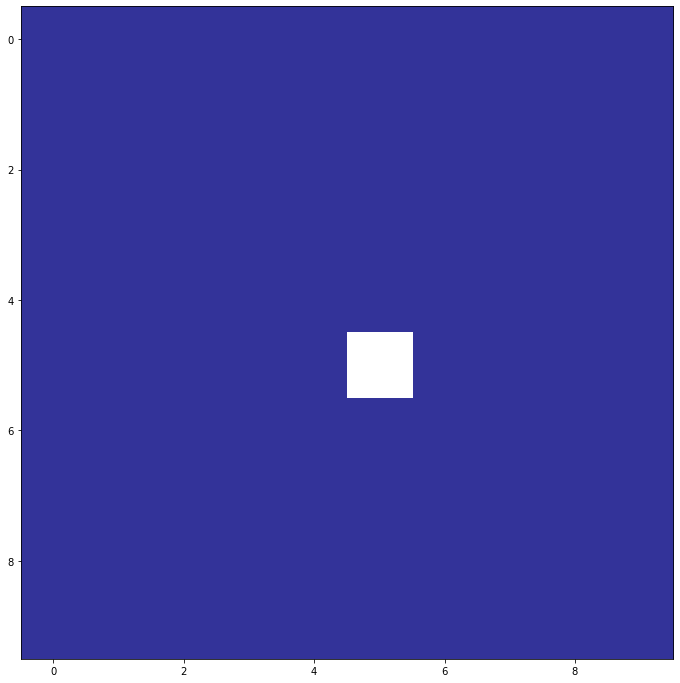

In [46]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(tmap, cmap=plt.cm.terrain)
fig.savefig("map.png")

In [71]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

class CellStep(object):
    def __init__(self, canvas):
        self.canvas = copy.deepcopy(canvas)
        self.canvas_padded = np.pad(canvas, pad_width=1, mode="edge")

    
        self.imap = np.arange(len(self.canvas.flatten())).reshape(self.canvas.shape)
        self.imap_padded = np.arange(len(self.canvas_padded.flatten())).reshape(self.canvas_padded.shape)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
    
    def step(self):
        """
        Water flows downhill into the ocean, from each point on and on
        
        
        This is the from out to in phylosophy, where water flow is calculated from other to here for each cell
        
        This is equivalent to the in to out phylosophy, just easier to implement vectorized
        """
        
        self.height_local = self.canvas
        self.height_shifted = np.array([self.canvas_padded.flat[ii] for ii in self.imap_shifted])
#         print(self.canvas)
        self.diffs = (self.height_local - self.height_shifted) # how much higher the neighbor cell is than this
        self.diffs[self.diffs < 0] = 0
        fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))
        landslide = self.diffs.sum(axis=0) * fractions *0.2# this is how much matter leaves this cell in each direction
#         print(landslide)
        self.height_local -= landslide.sum(axis=0)
        self.landslide = []
        for i, ii in enumerate(self.imap_unshifted):
            tmp = np.pad(landslide[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            self.landslide.append(tmp)
        self.landslide = np.array(self.landslide)
        self.height_local += self.landslide.sum(axis=0)
        
        self.canvas = self.height_local
        self.canvas_padded = np.pad(self.canvas, pad_width=1, mode="edge")
        print(self.canvas.sum())

    def flow(self, nstep=100):
        self.maps = []
        self.maps.append(self.canvas.copy())
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.maps.append(self.canvas.copy())

In [73]:
cs = CellStep(tmap)
cs.flow(1000)

10.0
10.0
10.0
10.0
10.0
10.000000000000002
10.0
10.000000000000002
10.0
10.000000000000004
10.000000000000002
10.000000000000002
10.0
10.000000000000002
10.0
10.0
10.0
10.000000000000002
10.0
10.000000000000002
9.999999999999998
10.0
10.0
10.0
10.0
10.000000000000002
10.0
10.000000000000002
10.0
10.0
9.999999999999998
10.0
10.0
10.0
10.0
10.000000000000002
10.0
9.999999999999998
9.999999999999998
10.000000000000002
9.999999999999998
10.000000000000002
10.0
10.0
10.0
10.0
10.000000000000002
10.0
10.0
10.0
9.999999999999998
9.999999999999998
9.999999999999998
10.0
10.000000000000002
9.999999999999998
9.999999999999998
10.0
10.0
10.0
10.000000000000002
10.0
10.000000000000002
10.0
10.0
9.999999999999998
10.0
10.000000000000002
10.000000000000002
10.0
10.0
10.000000000000002
10.0
9.999999999999998
10.0
10.0
10.000000000000002
10.0
10.0
10.000000000000002
10.0
9.999999999999998
10.0
9.999999999999998
10.0
10.0
9.999999999999998
9.999999999999998
10.000000000000002
10.0
9.999999999999998
10

/tmp/ipykernel_4817/3863157623.py:79: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))


9.999999999999998
9.999999999999998
10.0
10.000000000000002
10.000000000000002
10.000000000000002
9.999999999999998
9.999999999999998
10.0
10.000000000000002
9.999999999999998
10.000000000000002
10.0
9.999999999999998
9.999999999999998
10.0
10.0
9.999999999999996
10.0
10.000000000000002
10.0
10.000000000000002
10.0
9.999999999999996
10.000000000000002
10.0
10.000000000000002
9.999999999999998
10.0
10.0
9.999999999999998
10.0
9.999999999999998
10.0
9.999999999999998
10.0
9.999999999999996
9.999999999999996
10.000000000000002
9.999999999999998
9.999999999999996
10.0
9.999999999999998
9.999999999999998
9.999999999999998
9.999999999999998
9.999999999999998
10.0
9.999999999999996
9.999999999999998
10.0
9.999999999999998
10.0
10.0
10.0
10.0
9.999999999999998
9.999999999999998
10.0
10.0
10.0
9.999999999999996
9.999999999999998
10.0
10.000000000000002
9.999999999999998
9.999999999999998
9.999999999999998
10.0
10.000000000000002
10.0
9.999999999999998
9.999999999999998
10.000000000000002
10.0
9

In [68]:
maps = cs.maps

In [70]:
maps[3].sum()

10.0

KeyboardInterrupt: 

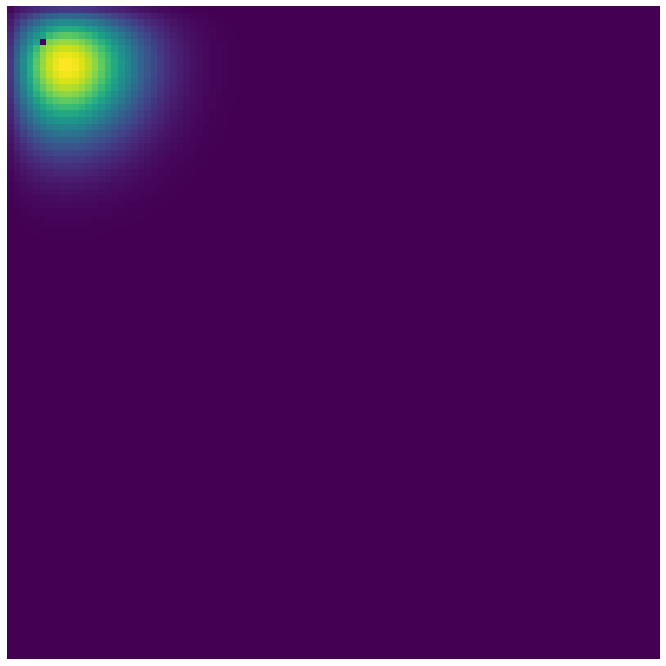

In [43]:

fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(maps[i], animated=True)] for i in np.arange(len(maps))]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
